# Task Overview

In this task, your goal is to verify the impact of data noise level in neural network training.
You should use MLP architecture trained on MNIST dataset (like in previous lab exercises).


We will experiment with two setups:
1. Pick X. Take X% of training examples and reassign their labels to random ones. Note that we don't change anything in the test set.
2. Pick X. During each training step, for each sample, change values of X% randomly selected pixels to random values. Note that we don't change anything in the test set.

For both setups, check the impact of various levels of noise (various values of X%) on model performance. Show plots comparing crossentropy (log-loss) and accuracy with varying X%, and also comparing two setups with each other.
Prepare short report briefly explaining the results and observed trends. Consider questions like "why accuracy/loss increases/decreases so quickly/slowly", "why Z is higher in setup 1/2" and any potentially surprising things you see on charts.

# Model definition and training.

In [ ]:
import random
import numpy as np
from torchvision import datasets, transforms
import random
import math
import sys
import matplotlib.pyplot as plt

In [ ]:
def load_mnist(path='.'):
    train_set = datasets.MNIST(path, train=True, download=True)
    x_train = train_set.data.numpy()
    _y_train = train_set.targets.numpy()
    
    test_set = datasets.MNIST(path, train=False, download=True)
    x_test = test_set.data.numpy()
    _y_test = test_set.targets.numpy()
    
    x_train = x_train.reshape((x_train.shape[0],28*28)) / 255.
    x_test = x_test.reshape((x_test.shape[0],28*28)) / 255.

    y_train = np.zeros((_y_train.shape[0], 10))
    y_train[np.arange(_y_train.shape[0]), _y_train] = 1
    
    y_test = np.zeros((_y_test.shape[0], 10))
    y_test[np.arange(_y_test.shape[0]), _y_test] = 1

    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_mnist()

In [ ]:
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    # Derivative of the sigmoid
    return sigmoid(z)*(1-sigmoid(z))

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

In [ ]:
class Network(object):
    def __init__(self, sizes, l2 = 0, momentum_rate = 0):
        # initialize biases and weights with random normal distr.
        # weights are indexed by target node first
        self.pixels_amount = 28 * 28
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases_start = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights_start = [np.random.randn(y, x) 
                        for x, y in zip(sizes[:-1], sizes[1:])]

        self.reset()
        self.l2 = l2
        self.momentum_rate = momentum_rate

    def feedforward(self, a):
        # Run the network on a batch
        a = a.T
        for b, w in zip(self.biases[:-1], self.weights[:-1]):
            a = sigmoid(np.matmul(w, a)+b)
        return softmax(np.matmul(self.weights[-1], a) + self.biases[-1])
    
    def update_mini_batch(self, mini_batch, eta):
        # Update networks weights and biases by applying a single step
        # of gradient descent using backpropagation to compute the gradient.
        # The gradient is computed for a mini_batch which is as in tensorflow API.
        # eta is the learning rate      
        nabla_b, nabla_w = self.backprop(mini_batch[0].T,mini_batch[1].T)
        self.momentum_w = [self.momentum_rate * momentum_w - (eta/len(mini_batch[0]))*nw for momentum_w, nw in zip(self.momentum_w, nabla_w)]
        self.weights = [w + nw 
                        for w, nw in zip(self.weights, self.momentum_w)]
        
        self.momentum_b = [self.momentum_rate * momentum_b - (eta/len(mini_batch[0]))*nb for momentum_b, nb in zip(self.momentum_b, nabla_b)]
        self.biases = [b + nb
                       for b, nb in zip(self.biases, self.momentum_b)]
        
    def backprop(self, x, y):
        # For a single input (x,y) return a pair of lists.
        # First contains gradients over biases, second over weights.
        g = x
        gs = [g] # list to store all the gs, layer by layer
        fs = [] # list to store all the fs, layer by layer
        for i, b, w in zip(range(self.num_layers), self.biases, self.weights):
            f = np.dot(w, g)+b
            fs.append(f)
            g = sigmoid(f) if i != self.num_layers - 2 else softmax(f)
            gs.append(g)
        # backward pass <- both steps at once 
        dLdg = self.cost_derivative(gs[-1], y)
        dLdfs = []
        i = 0
        for w,g in reversed(list(zip(self.weights,gs[1:]))):
            dLdf = np.multiply(dLdg,np.multiply(g,1-g)) if i != 0 else dLdg
            dLdfs.append(dLdf)
            dLdg = np.matmul(w.T, dLdf)
            i += 1
        
        dLdWs = [np.matmul(dLdf,g.T) + self.weight_decay(ind = i) for dLdf,g,i in zip(reversed(dLdfs),gs[:-1], range(self.num_layers))] 
        dLdBs = [np.sum(dLdf,axis=1).reshape(dLdf.shape[0],1) for dLdf in reversed(dLdfs)] 
        return (dLdBs,dLdWs)

    def evaluate(self, test_data):
        # Count the number of correct answers for test_data
        pred = np.argmax(self.feedforward(test_data[0]),axis=0)
        corr = np.argmax(test_data[1],axis=1).T
        return np.mean(pred==corr)
    
    def cost_derivative(self, output_activations, y):
        return output_activations-y
    
    def logloss_over_test(self, test_data):
        pred_prob = self.feedforward(test_data[0])
        gt_idx = np.argmax(test_data[1], axis = 1)
        ans = 0
        for v, i in zip(gt_idx, range(0, len(test_data[0]))):
            ans -= math.log(pred_prob[v][i])
        
        return ans
    
    def train(self, training_data, epochs, mini_batch_size, eta, test_data):
        x_train, y_train = training_data
        x_test, y_test = test_data

        for j in range(epochs):
            for i in range(x_train.shape[0] // mini_batch_size):
                x_mini_batch = x_train[(mini_batch_size*i):(mini_batch_size*(i+1))]
                y_mini_batch = y_train[(mini_batch_size*i):(mini_batch_size*(i+1))]
                self.update_mini_batch((x_mini_batch, y_mini_batch), eta)

        train_out = (self.evaluate(training_data), self.logloss_over_test(training_data))
        test_out = (self.evaluate(test_data), self.logloss_over_test(test_data))
        
        return (train_out, test_out)

    def weight_decay(self, ind = None):
        return self.l2 * self.weights[ind] * 2

    # In order to run few NNs on the same Network 
    # (basically I want to simulate several NNs with the same starting weights)
    # class I reset every data which may have been left from previous runs
    def reset(self):
        self.weights = np.array(self.weights_start, copy=True, dtype=object)
        self.biases = np.array(self.biases_start, copy=True, dtype=object)
        self.momentum_w = [np.zeros(shape=(y, x)) 
                        for x, y in zip(self.sizes[:-1], self.sizes[1:])]
        self.momentum_b = [np.zeros(shape=(y, 1)) for y in self.sizes[1:]]

# Training models in setup 1: with randomized labels.

Lets check if by any chance labels are distributed uniformly in that case it would make our job easier ;)

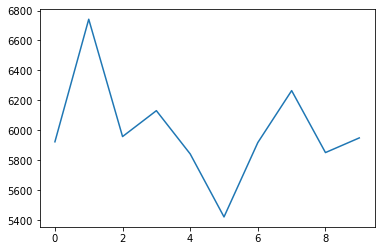

In [ ]:
lbl = np.argmax(y_train, axis=1)
label_distribution = np.histogram(lbl, range=(0, 10))[0]

plt.plot(range(0, 10), label_distribution)

This isn't uniform distribution so we will need to write our own random functions.

In [ ]:
# Function that returns probabilities of getting each digit in labels in a given dataset
def calculate_label_distribution(labels):
    # Calculating distribution of labels and dividing it by amount of labels to get probabilities
    return np.histogram(np.argmax(labels, axis=1), range=(0, 10))[0] / len(labels)

# Function that given labels and probability
# returns changed label as defined in task 1
def rand_label(labels, pX):
    # making copy of those labels not to change the original dataset
    new_labels = np.array(labels, copy=True, dtype=np.float64)
    # based on pX calculating the number of labels to change
    noise_len = math.floor(len(labels) * pX)
    # getting 'noise_len' number of indexes to change label
    noise_idx = random.sample(range(0, len(labels)), noise_len)
    # getting probabilities of getting each label
    distr = calculate_label_distribution(labels)
    
    for idx in noise_idx:
        # zero out the label vector
        new_labels[idx] = 0
        # choose random value for this vector, random value
        # can be the same as last one, but in the grand scheme 
        # of things it doesn't really matter
        new_labels[idx][np.random.choice(10, p = distr)] = 1
    return new_labels

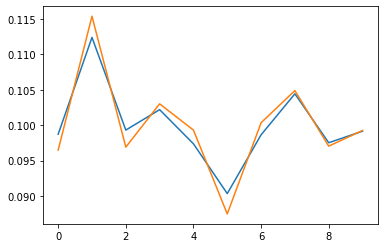

In [ ]:
# Distribution of y_train labels
plt.plot(range(0, 10), calculate_label_distribution(y_train))
# Distribution of our randomly generated distribution with pX = 1, so we change every label
plt.plot(range(0, 10), calculate_label_distribution(rand_label(y_train, 1)))
plt.show()

As tested above our function works near perfectly, so lets use them in our class!

In [ ]:
class Label_randomization(Network):

    def train(self, training_data, epochs, mini_batch_size, eta, test_data, pX):
        x_train, y_train = training_data
        x_test, y_test = test_data
            
        # Changing X% of labels into random ones.
        y_train_tainted = rand_label(y_train, pX)
        
        for j in range(epochs):
            for i in range(x_train.shape[0] // mini_batch_size):
                x_mini_batch = x_train[(mini_batch_size*i):(mini_batch_size*(i+1))]
                # Here is change between normal model training, we use y_train_tainted as minibatch labels
                y_mini_batch = y_train_tainted[(mini_batch_size*i):(mini_batch_size*(i+1))]
                self.update_mini_batch((x_mini_batch, y_mini_batch), eta)
           
        train_out = (self.evaluate(training_data), self.logloss_over_test(training_data))
        test_out = (self.evaluate(test_data), self.logloss_over_test(test_data))
        
        return (train_out, test_out)

In [ ]:
network_l = Label_randomization([784,30,10], l2=0.002, momentum_rate=0.5)

# lists to further make awesome plots!
label_multi_pX = list()
label_multi_train_acc = list()
label_multi_train_loss = list()
label_multi_test_acc = list()
label_multi_test_loss = list()

# I want to run whole process few times just to be sure if there is any variance
for iterations in range(0, 4):
    # X used
    prob = list()
    # test set accuracy
    test_acc = list()
    # test set loss
    test_loss = list()
    # training set accuracy
    train_acc = list()
    # training set loss
    train_loss = list()
    
    # running for some values of pX
    for pX in np.linspace(0.0, 1.0, 10):
        prob.append(pX)
        out = network_l.train((x_train, y_train), epochs=50, mini_batch_size=100, eta=3.0, test_data=(x_test, y_test), pX=pX)
        train_acc.append(out[0][0])
        train_loss.append(out[0][1])
        test_acc.append(out[1][0])
        test_loss.append(out[1][1])
        
        network_l.reset()

    label_multi_pX.append(prob)
    label_multi_train_acc.append(train_acc)
    label_multi_train_loss.append(train_loss)
    label_multi_test_acc.append(test_acc)
    label_multi_test_loss.append(test_loss)

In [ ]:
network_l = Label_randomization([784,30,10], l2=0.002, momentum_rate=0.5)

# lists to further make awesome plots!
# Duplicate from above to keep one
# convention of storing these values to save myself
# a hassle with plots
label_single_pX = list()
label_single_train_acc = list()
label_single_train_loss = list()
label_single_test_acc = list()
label_single_test_loss = list()

prob = list()
test_acc = list()
test_loss = list()
train_acc = list()
train_loss = list()

# This time I do single iteration but with many values of pX
for pX in np.linspace(0.0, 1.0, 30):
    prob.append(pX)
    out = network_l.train((x_train, y_train), epochs=20, mini_batch_size=100, eta=3.0, test_data=(x_test, y_test), pX=pX)
    train_acc.append(out[0][0])
    train_loss.append(out[0][1])
    test_acc.append(out[1][0])
    test_loss.append(out[1][1])

    network_l.reset()

label_single_pX.append(prob)
label_single_train_acc.append(train_acc)
label_single_train_loss.append(train_loss)
label_single_test_acc.append(test_acc)
label_single_test_loss.append(test_loss)

# Training models in setup 2: with randomized pixels.

In [ ]:
# constant value to have cleaner code
pixels_in_image = 28 * 28

Lets also firstly scout pixel distribution in search for uniform one.

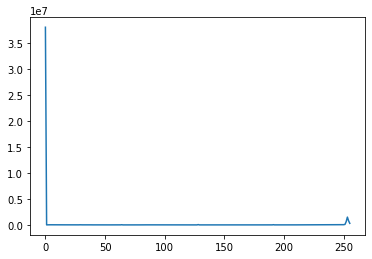

In [ ]:
# Calculating distribution this time number of bins is 256 because it is the amount of colors here
pixel_distribution = np.histogram(x_train, bins=256)[0]
plt.plot(range(0, 256), pixel_distribution)

And now without clearly dominating 0:

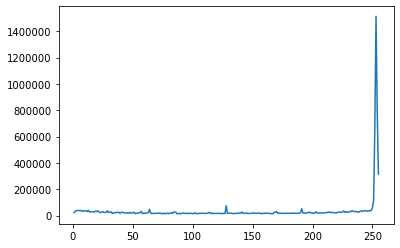

In [ ]:
plt.plot(range(1, 256), pixel_distribution[1:])

Now pixels with colors 251 - 255 are dominading, besides that it seems like a good candidate for uniform distribution, but it will be faster to do the same trick as previously, use np.random.choice with this exact distribution given!

In [ ]:
# Calculating pixel color distribution, same trick as previously
def calculate_pixel_distribution(images):
    # Calculate probability of appearance for each color
    return np.histogram(images, bins=256)[0] / (len(images) * pixels_in_image)

# Function randomizing pixels
# We cannot afford now to calculate distribution every
# function call, so we add argument distr in comparison to
# task 1 randomizing function
def rand_pixel(images, distr, pX):
    # saving the shape to devectorize after vectorizing
    im_shape = images.shape
    # flattening images to vectorize the function and get the answer faster
    images = images.flatten()
    # Changing random pixels with given as function argument distribution
    # sidenote: np.random.choice is far superior than random.sample optimization wise
    images[np.random.choice(images.size, size=int(images.size * pX), replace=False)] = \
                np.random.choice(256, int(images.size * pX), p=distr) / 255
    images = images.reshape(im_shape)
    return images

Lets test this function on a single digit:

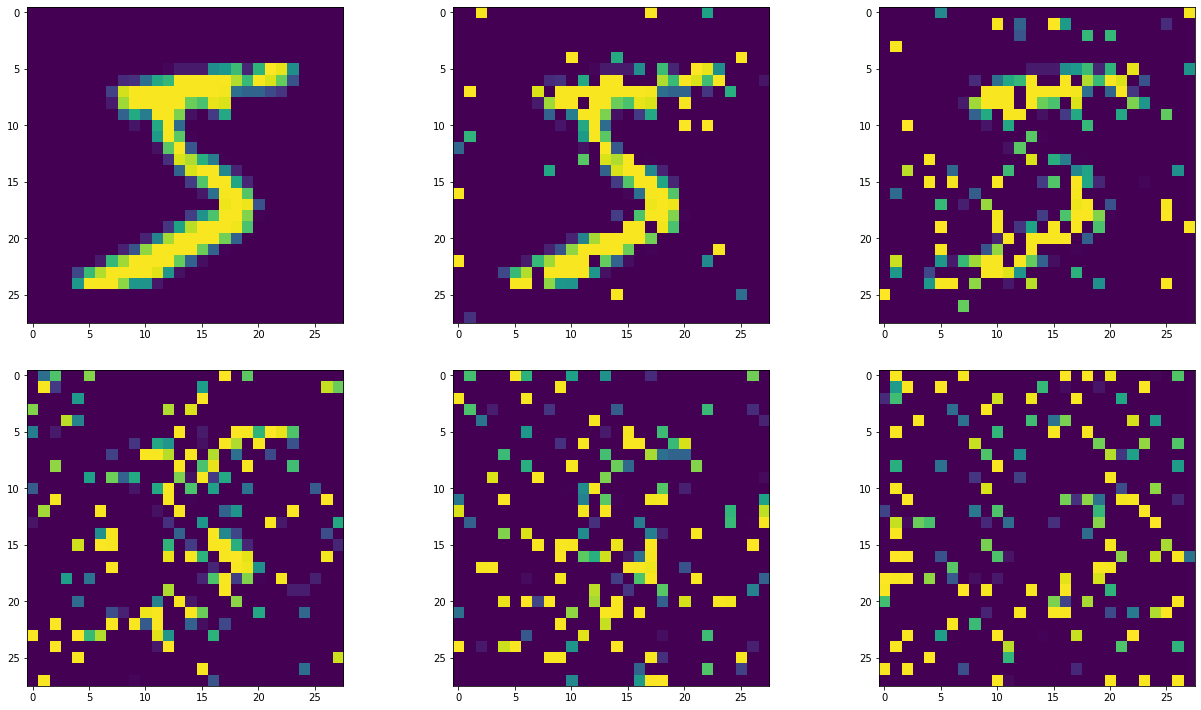

In [ ]:
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(18.5, 10.5)

distr = calculate_pixel_distribution(x_train)

ax[0, 0].imshow(rand_pixel(np.array([x_train[0]]), distr, 0).reshape(28, 28), interpolation='nearest')
ax[0, 1].imshow(rand_pixel(np.array([x_train[0]]), distr, 0.2).reshape(28, 28), interpolation='nearest')
ax[0, 2].imshow(rand_pixel(np.array([x_train[0]]), distr, 0.4).reshape(28, 28), interpolation='nearest')
ax[1, 0].imshow(rand_pixel(np.array([x_train[0]]), distr, 0.6).reshape(28, 28), interpolation='nearest')
ax[1, 1].imshow(rand_pixel(np.array([x_train[0]]), distr, 0.8).reshape(28, 28), interpolation='nearest')
ax[1, 2].imshow(rand_pixel(np.array([x_train[0]]), distr, 1.0).reshape(28, 28), interpolation='nearest')

fig.tight_layout(pad=3.0)

It works wonderful! And now lets check if our random distribution matches the real one:

[]

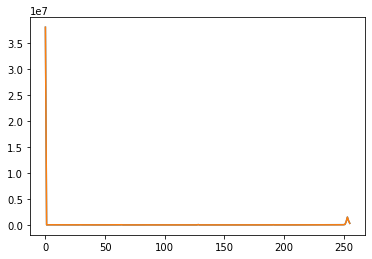

In [ ]:
real_pixel_distribution = np.histogram(x_train, bins=256)[0]
plt.plot(range(0, 256), pixel_distribution)

distr = calculate_pixel_distribution(x_train)
tainted_pixel_distribution = np.histogram(rand_pixel(x_train, distr, 1), bins=256)[0]
plt.plot(range(0, 256), tainted_pixel_distribution)
plt.plot()

We got an almost exact match! So lets use it in our train function:

In [ ]:
class Pixel_randomization(Network):
    def train(self, training_data, epochs, mini_batch_size, eta, pX, test_data):
        x_train, y_train = training_data
        x_test, y_test = test_data
            
        # Calculating pixel distribution once before training
        distr = calculate_pixel_distribution(x_train)
        
        for j in range(epochs):
            # Changing the noise every single epoch
            x_train_tainted = rand_pixel(x_train, distr, pX)
            for i in range(x_train_tainted.shape[0] // mini_batch_size):
                # using training dataset input with changed pixels
                x_mini_batch = x_train_tainted[(mini_batch_size*i):(mini_batch_size*(i+1))]
                y_mini_batch = y_train[(mini_batch_size*i):(mini_batch_size*(i+1))]
                self.update_mini_batch((x_mini_batch, y_mini_batch), eta)
           
        train_out = (self.evaluate(training_data), self.logloss_over_test(training_data))
        test_out = (self.evaluate(test_data), self.logloss_over_test(test_data))
        
        return (train_out, test_out)

In [ ]:
network = Pixel_randomization([784,30,10], l2=0.002, momentum_rate=0.5)

# Lists for plots
input_multi_pX = list()
input_multi_train_acc = list()
input_multi_train_loss = list()
input_multi_test_acc = list()
input_multi_test_loss = list()

for iterations in range(0, 4):
    # Lists for each iteration to use in plots
    prob = list()
    test_acc = list()
    test_loss = list()
    train_acc = list()
    train_loss = list()
    
    for pX in np.linspace(0.0, 1.0, 10):
        prob.append(pX)
        out = network.train((x_train, y_train), epochs=20, mini_batch_size=100, eta=3.0, test_data=(x_test, y_test), pX=pX)
        train_acc.append(out[0][0])
        train_loss.append(out[0][1])
        test_acc.append(out[1][0])
        test_loss.append(out[1][1])
        network.reset()

    input_multi_pX.append(prob)
    input_multi_train_acc.append(train_acc)
    input_multi_train_loss.append(train_loss)
    input_multi_test_acc.append(test_acc)
    input_multi_test_loss.append(test_loss)

In [ ]:
network = Pixel_randomization([784,30,10], l2=0.002, momentum_rate=0.5)

# Lists for plots
input_single_pX = list()
input_single_train_acc = list()
input_single_train_loss = list()
input_single_test_acc = list()
input_single_test_loss = list()

# Lists to keep consistency with multiple iterations
prob = list()
test_acc = list()
test_loss = list()
train_acc = list()
train_loss = list()

for pX in np.linspace(0.0, 1.0, 30):
    prob.append(pX)
    out = network.train((x_train, y_train), epochs=20, mini_batch_size=100, eta=3.0, test_data=(x_test, y_test), pX=pX)
    train_acc.append(out[0][0])
    train_loss.append(out[0][1])
    test_acc.append(out[1][0])
    test_loss.append(out[1][1])
    network.reset()

input_single_pX.append(prob)
input_single_train_acc.append(train_acc)
input_single_train_loss.append(train_loss)
input_single_test_acc.append(test_acc)
input_single_test_loss.append(test_loss)

# Plots and report.

# Multiple runs

I have ran my neural network few times with different starting wages to also observe the variance between the results.

###  Setup 2

On the sidenote I start with color randomization as it is easier to describe.

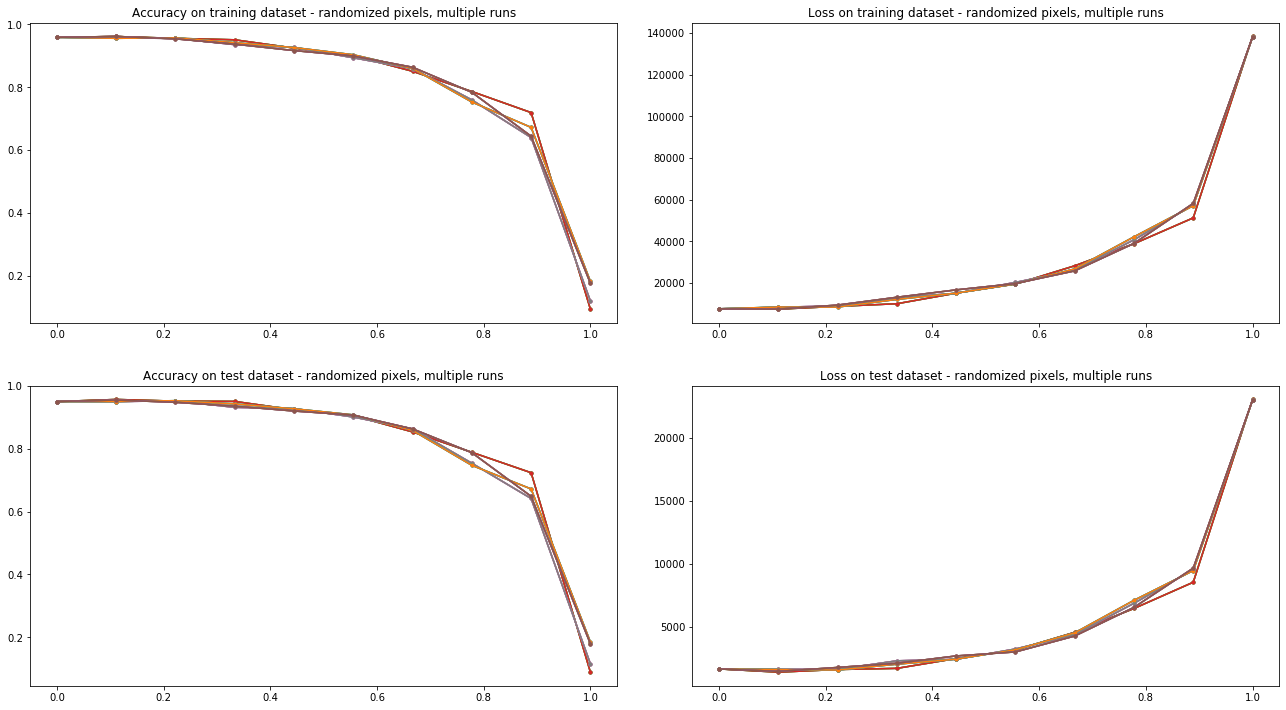

In [ ]:
fig, ax = plt.subplots(2, 2)

fig.set_size_inches(18.5, 10.5)

for idx in range(0, len(input_multi_pX)):
    for it in range(0, len(input_multi_pX)):
        # Training dataset
        ax[0, 0].set_title('Accuracy on training dataset - randomized pixels, multiple runs')
        ax[0, 0].plot(input_multi_pX[idx], input_multi_train_acc[idx], '.-')
        ax[0, 1].set_title('Loss on training dataset - randomized pixels, multiple runs')
        ax[0, 1].plot(input_multi_pX[idx], input_multi_train_loss[idx], '.-')

        # Test dataset
        ax[1, 0].set_title('Accuracy on test dataset - randomized pixels, multiple runs')
        ax[1, 0].plot(input_multi_pX[idx], input_multi_test_acc[idx], '.-')
        ax[1, 1].set_title('Loss on test dataset - randomized pixels, multiple runs')
        ax[1, 1].plot(input_multi_pX[idx], input_multi_test_loss[idx], '.-')
    
    
fig.tight_layout(pad=3.0)

The loss up to about X = 80 - 90% is almost linear, this can be justified because the image still preserve its key features, looking back at distorted '5' digit when making setup to second task even at X = 80% human eye can still see some similarities with the original image and as we see most digits are distinct enough to be recognized even at this tremendous noise level.

The accuracy beacause of that up to the spike point is decreasing very slowly, the digits are distinct enough to have low logloss so the softmax will surely with great accuracy will chose the best fit.

That spike can be explained that above 80% every numbers starts to blend and have similar accuracy as others, because distorted that much digits lose their key characteristics on which our neural network probably distinguished them, so our accuracy drops down to about 10% accuracy - it just guesses which digit is on the original not distorted image.

Because of this spike we can deduce that we can compress the image to 20% of its original size and we would have similar accuracy as in X = 80%.

## Setup 1

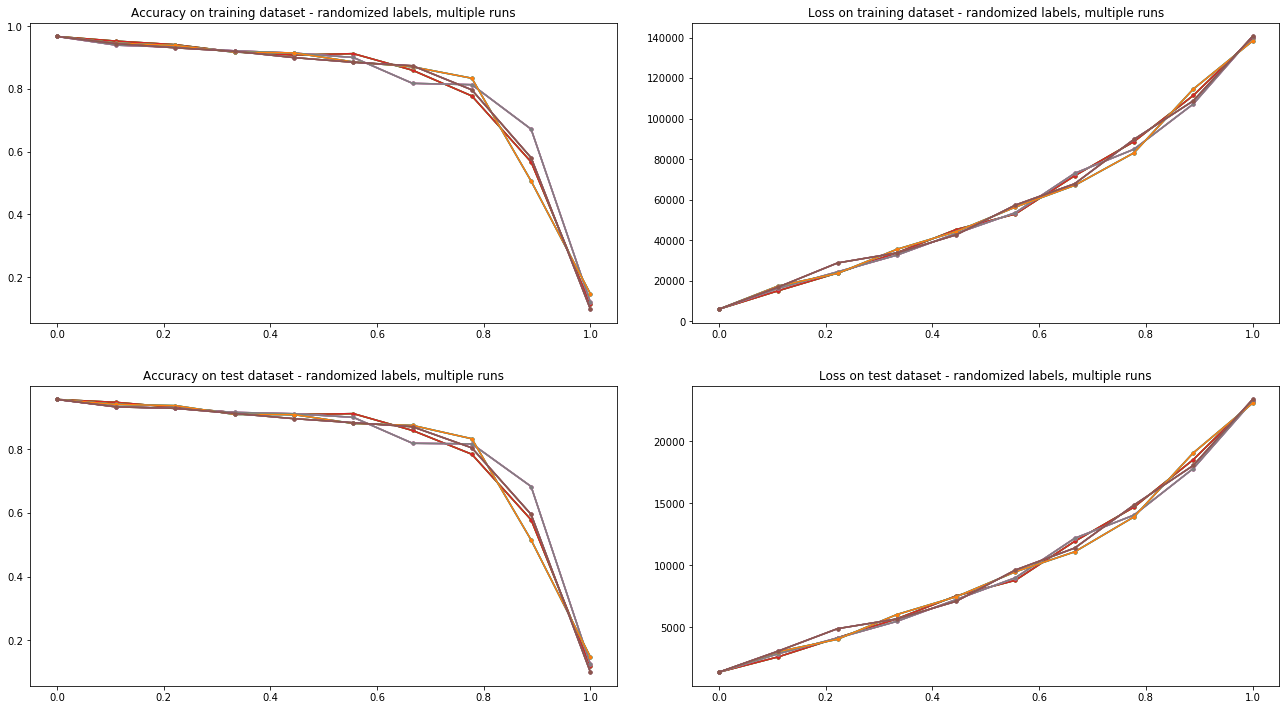

In [ ]:
fig, ax = plt.subplots(2, 2)

fig.set_size_inches(18.5, 10.5)

for idx in range(0, len(label_multi_pX)):
    for it in range(0, len(label_multi_pX)):
        # Training dataset
        ax[0, 0].set_title('Accuracy on training dataset - randomized labels, multiple runs')
        ax[0, 0].plot(label_multi_pX[idx], label_multi_train_acc[idx], '.-')
        ax[0, 1].set_title('Loss on training dataset - randomized labels, multiple runs')
        ax[0, 1].plot(label_multi_pX[idx], label_multi_train_loss[idx], '.-')

        # Test dataset
        ax[1, 0].set_title('Accuracy on test dataset - randomized labels, multiple runs')
        ax[1, 0].plot(label_multi_pX[idx], label_multi_test_acc[idx], '.-')
        ax[1, 1].set_title('Loss on test dataset - randomized labels, multiple runs')
        ax[1, 1].plot(label_multi_pX[idx], label_multi_test_loss[idx], '.-')
    
    
fig.tight_layout(pad=3.0)

The loss is linear in relation to X, this may happen because in case of pixels we were changing color somewhat uniformly along the whole dataset, now we are just lineary invalidating more and more data in our training set. Thats why there isn't sudden spike in loss when we reach X = 80 - 90%.

The accuracy is decreasing very slowly up to the X = 80%, we can see this point as the tipping point for accuracy, because as the loss increases the less probability (softmax wise) we have on our correct answer and as we can observe this is the point that wrong answers start to dominate up to accuracy of 10% where each answer has the same probability.

# Single runs

## Setup 2

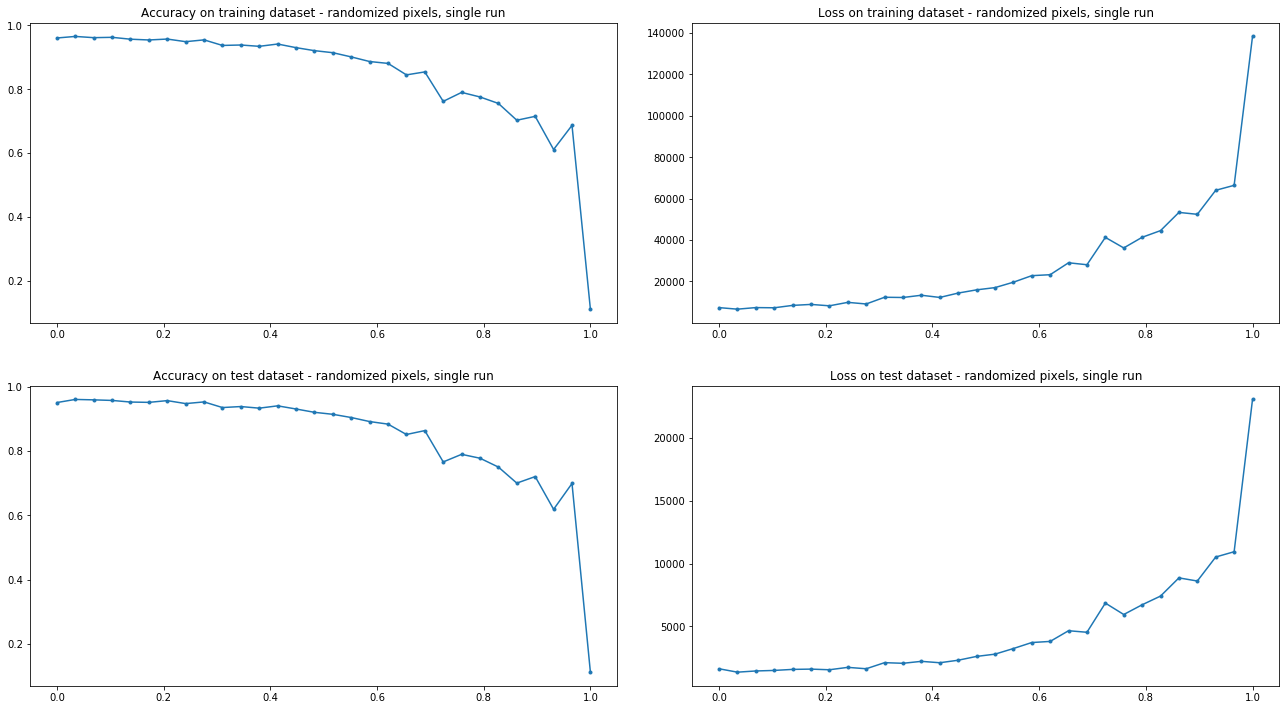

In [ ]:
fig, ax = plt.subplots(2, 2)

fig.set_size_inches(18.5, 10.5)

for idx in range(0, len(input_single_pX)):
    for it in range(0, len(input_single_pX)):
        # Training dataset
        ax[0, 0].set_title('Accuracy on training dataset - randomized pixels, single run')
        ax[0, 0].plot(input_single_pX[idx], input_single_train_acc[idx], '.-')
        ax[0, 1].set_title('Loss on training dataset - randomized pixels, single run')
        ax[0, 1].plot(input_single_pX[idx], input_single_train_loss[idx], '.-')

        # Test dataset
        ax[1, 0].set_title('Accuracy on test dataset - randomized pixels, single run')
        ax[1, 0].plot(input_single_pX[idx], input_single_test_acc[idx], '.-')
        ax[1, 1].set_title('Loss on test dataset - randomized pixels, single run')
        ax[1, 1].plot(input_single_pX[idx], input_single_test_loss[idx], '.-')

fig.tight_layout(pad=3.0)

More detailed plots of our accuracy and loss while randomizing pixel colors shows us that up to about X = 60% our accuracy is very stable, then up to X = 95% we have bigger drop and as we reach X = 100% the accuracy raches 10%, while the loss preserves also the same pattern.

## Setup 1

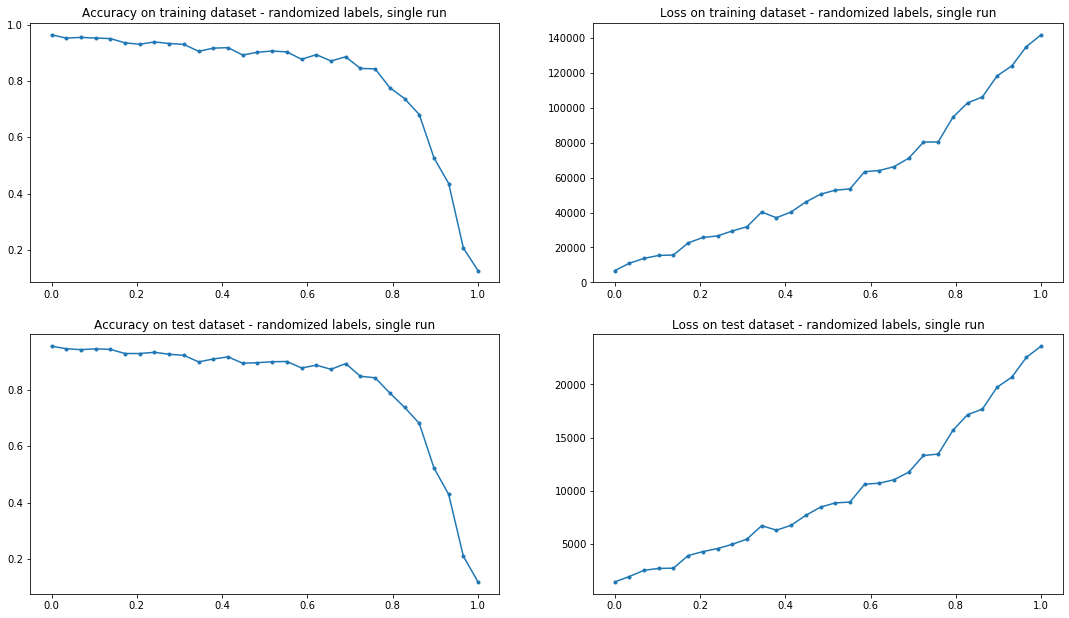

In [ ]:
fig, ax = plt.subplots(2, 2)

fig.set_size_inches(18.5, 10.5)

for idx in range(0, len(label_single_pX)):
    for it in range(0, len(label_single_pX)):
        # Training dataset
        ax[0, 0].set_title('Accuracy on training dataset - randomized labels, single run')
        ax[0, 0].plot(label_single_pX[idx], label_single_train_acc[idx], '.-')
        ax[0, 1].set_title('Loss on training dataset - randomized labels, single run')
        ax[0, 1].plot(label_single_pX[idx], label_single_train_loss[idx], '.-')

        # Test dataset
        ax[1, 0].set_title('Accuracy on test dataset - randomized labels, single run')
        ax[1, 0].plot(label_single_pX[idx], label_single_test_acc[idx], '.-')
        ax[1, 1].set_title('Loss on test dataset - randomized labels, single run')
        ax[1, 1].plot(label_single_pX[idx], label_single_test_loss[idx], '.-')

More detailed plots of our accuracy and loss while randomizing labels shows us that the tipping point of accuracy is about X = 80%, we can also see the linearity of loss in greater detail.

#  Comparison between two setups

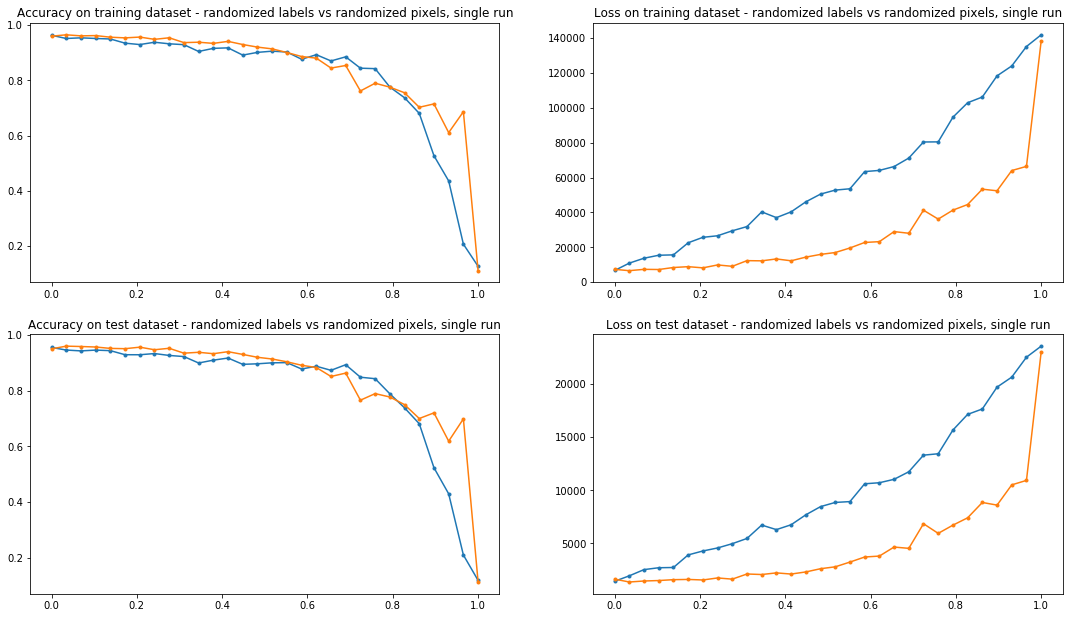

In [ ]:
fig, ax = plt.subplots(2, 2)

fig.set_size_inches(18.5, 10.5)

for idx in range(0, len(label_single_pX)):
    for it in range(0, len(label_single_pX)):
        # Training dataset
        ax[0, 0].set_title('Accuracy on training dataset - randomized labels vs randomized pixels, single run')
        ax[0, 0].plot(label_single_pX[idx], label_single_train_acc[idx], '.-')
        ax[0, 0].plot(input_single_pX[idx], input_single_train_acc[idx], '.-')
        ax[0, 1].set_title('Loss on training dataset - randomized labels vs randomized pixels, single run')
        ax[0, 1].plot(label_single_pX[idx], label_single_train_loss[idx], '.-')
        ax[0, 1].plot(input_single_pX[idx], input_single_train_loss[idx], '.-')

        # Test dataset
        ax[1, 0].set_title('Accuracy on test dataset - randomized labels vs randomized pixels, single run')
        ax[1, 0].plot(label_single_pX[idx], label_single_test_acc[idx], '.-')
        ax[1, 0].plot(input_single_pX[idx], input_single_test_acc[idx], '.-')
        ax[1, 1].set_title('Loss on test dataset - randomized labels vs randomized pixels, single run')
        ax[1, 1].plot(label_single_pX[idx], label_single_test_loss[idx], '.-')
        ax[1, 1].plot(input_single_pX[idx], input_single_test_loss[idx], '.-')

Orange line - randomized pixels \
Blue line - randomized labels

Adding noise uniformly to the dataset input behaves slightly better overall, this may be because adding noise does not invalidate a chunk of dataset, when we reach X = 100% the models accuracy and loss are equal, because in one case we're working on complete noise from input side and in the other on the output side.

Valid digit as the X increases has bigger probability (softmax wise) when randomizing colors, it is more sure of the answer.

#  Final thougts

Overall neural networks are very resistant to high noise levels. \
When comparing accuracy and loss on training and test datasets they are almost identical, we could combine not noised training and test datasets to have more data to test against, because of it. \
So basically adding noise to data can increase the size of our dataset therefore increase
accuracy of our predictions. \
As shown in runs with different wages at some Xs the accuracies can differ more than 10%, but overall the plots look very similar.